# Load data

In [2]:
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

SAMPLE_DIR = DATA_DIR / "samples"

TRAIN_DIR = DATA_DIR / "train"
NORMAL_DIR = TRAIN_DIR / "normal"
SPOOF_DIR = TRAIN_DIR / "spoof"

DEV_DIR = DATA_DIR / "dev"
DEV_NORMAL_DIR = DEV_DIR / "normal"
DEV_SPOOF_DIR = DEV_DIR / "spoof"

TEST_DIR = DATA_DIR / "test"
TEST_NORMAL_DIR = TEST_DIR / "normal"
TEST_SPOOF_DIR = TEST_DIR / "spoof"

(-0.5, 1079.5, 1919.5, -0.5)

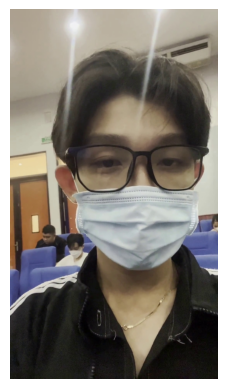

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = list(NORMAL_DIR.glob("*.jpg"))[5]
img = Image.open(img_path)
plt.imshow(img)
plt.axis("off")


In [4]:
normal_samples = list(NORMAL_DIR.glob("*.jpg"))
spoof_samples = list(SPOOF_DIR.glob("*.jpg"))
len(normal_samples), len(spoof_samples)

(1432, 1368)

In [5]:
dev_normal_samples = list(DEV_NORMAL_DIR.glob("*.jpg"))
dev_spoof_samples = list(DEV_SPOOF_DIR.glob("*.jpg"))
len(dev_normal_samples), len(dev_spoof_samples)

(551, 524)

In [6]:
for img_path in NORMAL_DIR.glob("*.jpg"):
  img = Image.open(img_path)
  if img.size[0] < 448 or img.size[1] <= 448:
    print(f"{img_path}: {img.size}")

/home/nhatminh/Desktop/cake-bank-classifier-project/data/raw/train/normal/1877_1.jpg: (368, 656)
/home/nhatminh/Desktop/cake-bank-classifier-project/data/raw/train/normal/645_4.jpg: (320, 576)
/home/nhatminh/Desktop/cake-bank-classifier-project/data/raw/train/normal/340_2.jpg: (320, 576)
/home/nhatminh/Desktop/cake-bank-classifier-project/data/raw/train/normal/645_3.jpg: (320, 576)
/home/nhatminh/Desktop/cake-bank-classifier-project/data/raw/train/normal/1401_3.jpg: (240, 480)
/home/nhatminh/Desktop/cake-bank-classifier-project/data/raw/train/normal/1401_4.jpg: (240, 480)
/home/nhatminh/Desktop/cake-bank-classifier-project/data/raw/train/normal/1345_4.jpg: (416, 852)
/home/nhatminh/Desktop/cake-bank-classifier-project/data/raw/train/normal/1366_3.jpg: (320, 576)
/home/nhatminh/Desktop/cake-bank-classifier-project/data/raw/train/normal/1433_4.jpg: (368, 656)
/home/nhatminh/Desktop/cake-bank-classifier-project/data/raw/train/normal/422_2.jpg: (384, 852)
/home/nhatminh/Desktop/cake-bank-c

# Preprocessing

In [ ]:
import os
from pathlib import Path


for folder in TRAIN_DIR.iterdir():
  print(folder)
  print(folder.name)

os.listdir(TRAIN_DIR)

/home/nhatminh/Desktop/cake-bank-classifier-project/data/raw/train/spoof
spoof
/home/nhatminh/Desktop/cake-bank-classifier-project/data/raw/train/normal
normal


['spoof', 'normal']

In [23]:
from classifier.data_module.dataloader import LivenessDataLoader


load_provider = LivenessDataLoader(
  train_path=TRAIN_DIR,
  dev_path=DEV_DIR,
  test_path=TEST_DIR,
  samples_path=SAMPLE_DIR
)


load_provider.setup("samples")
samples_loader = load_provider.get_samples_loader()
load_provider.setup('fit')
train_loader = load_provider.get_train_loader()
dev_loader = load_provider.get_dev_loader()

In [24]:
images, labels = next(iter(samples_loader))
print(images.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LivenessCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # (B,128,1,1)
        )

        self.classifier = nn.Linear(128, 2)

    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)        # (B,128)
        logits = self.classifier(x)
        return logits


In [26]:
from tqdm.auto import tqdm
from classifier.evaluations import compute_metrics

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
        
    pbar = tqdm(loader, desc="Train", leave=False)

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.long().to(device)
        
        optimizer.zero_grad()
        logits = model(images)
            
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    return total_loss / len(loader)


In [27]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0

    all_labels = []
    all_preds = []
    all_probs = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.long().to(device)

        logits = model(images)          # (B, 2)
        loss = criterion(logits, labels)
        total_loss += loss.item()

        probs = torch.softmax(logits, dim=1)   # (B, 2)
        preds = torch.argmax(probs, dim=1)     # (B,)

        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs[:, 1].cpu())    # prob of class 1

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    y_prob = torch.cat(all_probs).numpy()

    metrics = compute_metrics(y_true, y_pred, y_prob)
    return total_loss / len(loader), metrics


In [ ]:
import torch.nn as nn
from classifier.regularizations import EarlyStopping
import mlflow

NUM_EPOCHS = 3
ETA_MIN = 1e-4
mlflow.set_experiment("Liveness Baseline")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LivenessCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS,
                                                     eta_min=ETA_MIN)
early_stopping = EarlyStopping(patience=5, delta=0.01, verbose=True)


with mlflow.start_run():
    mlflow.log_params({"learning_rate": 1e-3, "batch_size": 32, "epochs": NUM_EPOCHS})
    
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

        train_loss = train_one_epoch(
            model,
            samples_loader,
            optimizer,
            criterion,
            device
        )

        val_loss, val_metrics = evaluate(
            model,
            dev_loader,
            criterion,
            device
        )
        
        scheduler.step()
        early_stopping(val_loss, model)

        if early_stopping(val_loss, model):
            break
        
        mlflow.log_metrics({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_acc": val_metrics["accuracy"],
            "val_precision": val_metrics["precision"],
            "val_recall": val_metrics["recall"],
            "val_roc_auc": val_metrics["roc_auc"],
            "val_avg_precision": val_metrics["avg_precision"],
            "val_f1_score": val_metrics["f1_score"]
        })
        
        print(
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Acc: {val_metrics['accuracy']:.4f}"
        )
    mlflow.pytorch.log_model(model, name="model") 


2025/12/26 22:30:39 INFO mlflow.tracking.fluent: Experiment with name 'Liveness Baseline' does not exist. Creating a new experiment.



Epoch 1/3


/home/nhatminh/Desktop/cake-bank-classifier-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Validation loss decreased (inf --> 0.696502).  Saving model ...
EarlyStopping counter: 1 out of 5
Train Loss: 0.6544 | Val Loss: 0.6965 | Val Acc: 0.5126

Epoch 2/3


EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
Train Loss: 0.5617 | Val Loss: 0.7451 | Val Acc: 0.5135

Epoch 3/3


2025/12/26 22:34:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Train Loss: 0.5641 | Val Loss: 0.8549 | Val Acc: 0.5135


2025/12/26 22:34:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/26 22:34:52 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/26 22:34:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [ ]:
torch.save(
    {
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
    },
    "liveness_cnn.pt"
)
